In [4]:
import torch
from torch import nn
import numpy as np
from PolConfML.model import Network, Dataset
from PolConfML.utils import load_descs, save_descs
import time
import matplotlib.pyplot as plt

dtype = torch.float32

In [5]:
path = 'data_TiO2/split/'

keys = ['S0_A','S0_B','S1_A','S1_B','S2_A','S2_B']

# train
descs_train, indices_train = load_descs(path+'train/',keys)
Y_train = np.array(np.load(path+'train/Y.npy'))
defects_train = np.load(path+'train/defect.npy')
n = [descs_train[site].shape[0] for site in descs_train]

#val
descs_val,indices_val = load_descs(path+'val/',keys)
Y_val = np.load(path+'val/Y.npy')
defects_val = np.load(path+'val/defect.npy')

# test
descs_test,  indices_test = load_descs(path+'test/',keys)
Y_test = np.load(path+'test/Y.npy')
defects_test = np.load(path+'test/defect.npy')

# data
data_train = Dataset(descs_train, indices_train, Y_train, defects_train)
data_train.kernel(0.3)

data_val = Dataset(descs_val, indices_val, Y_val, defects_val)
data_val.descs = data_train.kernel_test(data_val)

data_test = Dataset(descs_test, indices_test, Y_test, defects_test)
data_test.descs = data_train.kernel_test(data_test)

In [6]:
net = Network(n)
criterion = nn.MSELoss(reduction='sum')
batch_size = 64

learn_curve_train = []
learn_curve_val = []
epochs = []
lowest_loss = 1000

optimizer = torch.optim.Adam(net.parameters(),lr=0.0002,eps=1e-8, weight_decay=0.1)
#optimizer = torch.optim.SGD(net.parameters(),lr=0.0001,weight_decay=0.1,)
start = time.time()
losses = []
for epoch in range(30001):
    #net = net.double()
    optimizer.zero_grad()
    loss = 0
    for i in np.random.randint(0,len(data_train),size=batch_size):
        x,y,ov = data_train[i]
        loss+=criterion(net(x),y)*9/(2*ov)

    loss.backward()

    with torch.no_grad():
        for i,param in enumerate(net.parameters()):
            if torch.isnan(torch.norm(param.grad)):
                param.grad[torch.isnan(param.grad).nonzero()] = 0
                
    optimizer.step()
    losses.append(loss.item()/batch_size)
    if epoch%100 == 0:
        end = time.time()
        val_loss = []
        with torch.no_grad():
            for (x),y,ov in data_val:
                val_loss.append((criterion(net(x),y)*9)/(2*ov).item())
        learn_curve_train.append(np.mean(losses))
        learn_curve_val.append(np.mean(val_loss))
        epochs.append(epoch)
        print('Epoch : %d \tLoss : %.6f \tVal_Loss : %.6f\tTime : %.3f seconds ' % (epoch, 
                                                                                    learn_curve_train[-1],
                                                                                    learn_curve_val[-1], 
                                                                                    end - start))
        if learn_curve_val[-1] < lowest_loss:
            lowest_loss = learn_curve_val[-1].copy()
            torch.save(net, 'data_TiO2/model.pt')
            print('saved model')
        start = time.time()
        losses = []

Epoch : 0 	Loss : 9.797710 	Val_Loss : 6.768881	Time : 0.775 seconds 
saved model
Epoch : 100 	Loss : 0.383231 	Val_Loss : 0.062266	Time : 2.122 seconds 
saved model
Epoch : 200 	Loss : 0.052782 	Val_Loss : 0.043465	Time : 2.070 seconds 
saved model
Epoch : 300 	Loss : 0.040713 	Val_Loss : 0.036794	Time : 2.085 seconds 
saved model
Epoch : 400 	Loss : 0.036827 	Val_Loss : 0.037902	Time : 2.063 seconds 
Epoch : 500 	Loss : 0.033629 	Val_Loss : 0.036260	Time : 2.071 seconds 
saved model
Epoch : 600 	Loss : 0.030817 	Val_Loss : 0.037223	Time : 2.079 seconds 
Epoch : 700 	Loss : 0.029239 	Val_Loss : 0.029543	Time : 2.064 seconds 
saved model
Epoch : 800 	Loss : 0.028039 	Val_Loss : 0.030772	Time : 2.065 seconds 
Epoch : 900 	Loss : 0.025410 	Val_Loss : 0.028230	Time : 2.057 seconds 
saved model
Epoch : 1000 	Loss : 0.024552 	Val_Loss : 0.028344	Time : 2.059 seconds 
Epoch : 1100 	Loss : 0.023334 	Val_Loss : 0.025277	Time : 2.060 seconds 
saved model
Epoch : 1200 	Loss : 0.022119 	Val_Loss 

In [7]:
net = torch.load('data_TiO2/model.pt')

# results

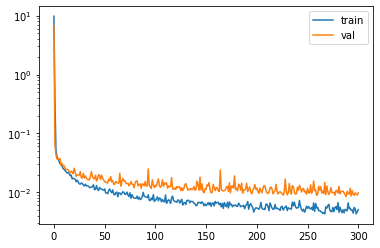

In [8]:
import matplotlib.pyplot as plt
plt.semilogy(learn_curve_train, label='train')
plt.semilogy(learn_curve_val, label='val')
plt.legend()

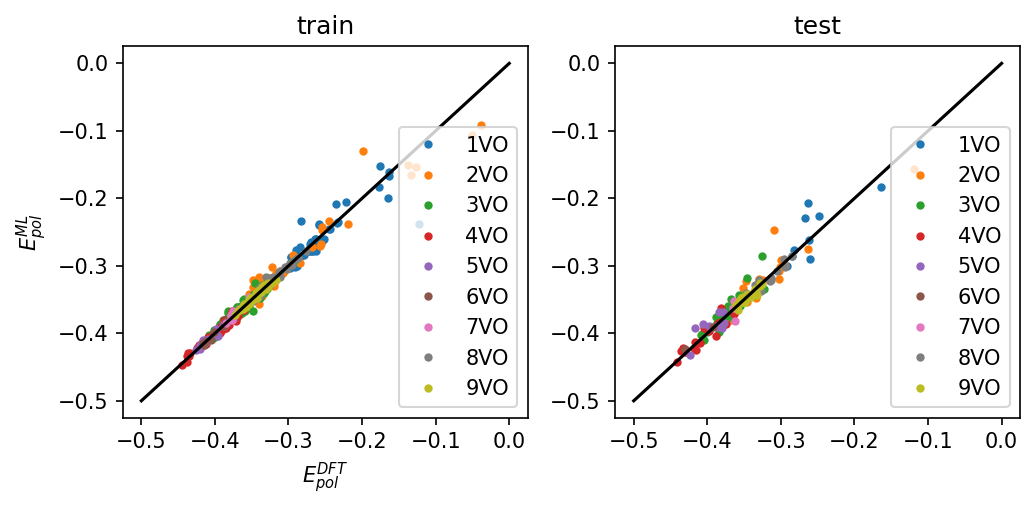

In [9]:
plt.figure(figsize=(7,3.5),dpi=150)
k=1
res = {title:{label:None for label in ['true', 'pred', 'nbs']} for title in ['train', 'test']}
for data,title in zip([data_train, data_test],['train','test']):

    true = []
    pred = []
    nbs = []
    if title=='test':
        for (x),y,ov in data_val:
            true.append(y/(2*ov))
            pred.append(net(x).item()/(2*ov))
            nbs.append(ov.item())
        for (x),y,ov in data_test:
            true.append(y/(2*ov))
            pred.append(net(x).item()/(2*ov))
            nbs.append(ov.item())
    else:
        for (x),y,ov in data:
            true.append(y/(2*ov))
            pred.append(net(x).item()/(2*ov))
            nbs.append(ov.item())
    
    
    true = np.array(true)
    pred = np.array(pred)
    nbs = np.array(nbs)
    res[title]['true'] = true
    res[title]['pred'] = pred
    res[title]['nbs'] = nbs
    plt.subplot(1,2,k)
    plt.title(title)
    for i in range(1,10):
        plt.plot(true[nbs==i],pred[nbs==i],'.',label=str(i)+'VO')
    plt.plot([-0.5,-0.0],[-0.5,-0.0],'k')
    plt.legend()
    if k==1:
        plt.xlabel('$E_{pol}^{DFT}$')
        plt.ylabel('$E_{pol}^{ML}$')
    k+=1
plt.tight_layout()

In [12]:
print('MSE training:\t', np.mean((res['train']['true']-res['train']['pred'])**2))
print('MSE test:\t', np.mean((res['test']['true']-res['test']['pred'])**2))

MSE training:	 0.00012731364
MSE test:	 0.00016643581


# split by defect

In [16]:
res ={i:{
    label:{
        'true':None, 'pred':None, 'nbs':None
    } for label in ['train', 'val', 'test']} 
      for i in range(1,10)}

keys_all = ['S0_A','S0_B','S1_A','S1_B','S2_A','S2_B']
keys_8 = ['S0_A','S0_B','S1_A','S1_B','S2_A']

for j in range(1,10):
    print(j)
    path = 'data_TiO2/split_defect/'+str(j)+'VO/'
    
    if j != 8:
        keys = keys_all
    else:
        keys = keys_8
    
    # train
    descs_train, indices_train = load_descs(path+'train/',keys)
    Y_train = np.array(np.load(path+'train/Y.npy'))
    defects_train = np.load(path+'train/defect.npy')
    n = [descs_train[site].shape[0] for site in descs_train]

    #val
    descs_val,indices_val = load_descs(path+'val/',keys)
    Y_val = np.load(path+'val/Y.npy')
    defects_val = np.load(path+'val/defect.npy')

    # test
    descs_test,  indices_test = load_descs(path+'test/',keys)
    Y_test = np.load(path+'test/Y.npy')
    defects_test = np.load(path+'test/defect.npy')

    # data
    data_train = Dataset(descs_train, indices_train, Y_train, defects_train)
    data_train.kernel(0.3)

    data_val = Dataset(descs_val, indices_val, Y_val, defects_val)
    data_val.descs = data_train.kernel_test(data_val)

    data_test = Dataset(descs_test, indices_test, Y_test, defects_test)
    data_test.descs = data_train.kernel_test(data_test)
    
    net = Network(n)
    criterion = nn.MSELoss(reduction='sum')
    batch_size = 64

    learn_curve_train = []
    learn_curve_val = []
    epochs = []

    optimizer = torch.optim.Adam(net.parameters(),lr=0.0002,eps=1e-8, weight_decay=0.1)
    #optimizer = torch.optim.SGD(net.parameters(),lr=0.0001,weight_decay=0.1,)
    start = time.time()
    losses = []
    for epoch in range(5001):
        #net = net.double()
        optimizer.zero_grad()
        loss = 0
        for i in np.random.randint(0,len(data_train),size=batch_size):
            (x),y,ov = data_train[i]
            loss+=criterion(net(x),y)*9/(2*ov)

        loss.backward()

        with torch.no_grad():
            for i,param in enumerate(net.parameters()):
                if torch.isnan(torch.norm(param.grad)):
                    param.grad[torch.isnan(param.grad).nonzero()] = 0

        optimizer.step()
        losses.append(loss.item()/batch_size)
        if epoch%100 == 0:
            end = time.time()
            val_loss = []
            with torch.no_grad():
                for (x),y,ov in data_val:
                    val_loss.append((criterion(net(x),y)*9/(2*ov)).item())
            learn_curve_train.append(np.mean(losses))
            learn_curve_val.append(np.mean(val_loss))
            epochs.append(epoch)
            print('Epoch : %d \tLoss : %.6f \tVal_Loss : %.6f\tTime : %.3f seconds ' % (epoch, 
                                                                                        learn_curve_train[-1],
                                                                                        learn_curve_val[-1], 
                                                                                        end - start))
            start = time.time()
            losses = []
            
    for data,title in zip([data_train, data_val, data_test],['train','val','test']):
        true = []
        pred = []
        nbs = []

        for (x),y,ov in data:
            true.append(y/(2*ov))
            pred.append(net(x).item()/(2*ov))
            nbs.append(ov.item())
        true = np.array(true)
        pred = np.array(pred)
        nbs = np.array(nbs)
        res[j][title]['true'] = true
        res[j][title]['pred'] = pred
        res[j][title]['nbs'] = nbs
            

1
Epoch : 0 	Loss : 9.505614 	Val_Loss : 6.669661	Time : 0.022 seconds 
Epoch : 100 	Loss : 0.389465 	Val_Loss : 0.052249	Time : 2.075 seconds 
Epoch : 200 	Loss : 0.053990 	Val_Loss : 0.041277	Time : 2.086 seconds 
Epoch : 300 	Loss : 0.041591 	Val_Loss : 0.035895	Time : 2.069 seconds 
Epoch : 400 	Loss : 0.036785 	Val_Loss : 0.034285	Time : 2.073 seconds 
Epoch : 500 	Loss : 0.032430 	Val_Loss : 0.030635	Time : 2.086 seconds 
Epoch : 600 	Loss : 0.030262 	Val_Loss : 0.029818	Time : 2.064 seconds 
Epoch : 700 	Loss : 0.027734 	Val_Loss : 0.026832	Time : 2.076 seconds 
Epoch : 800 	Loss : 0.026171 	Val_Loss : 0.024440	Time : 2.080 seconds 
Epoch : 900 	Loss : 0.023911 	Val_Loss : 0.022644	Time : 2.074 seconds 
Epoch : 1000 	Loss : 0.023938 	Val_Loss : 0.022079	Time : 2.088 seconds 
Epoch : 1100 	Loss : 0.022941 	Val_Loss : 0.020492	Time : 2.068 seconds 
Epoch : 1200 	Loss : 0.020505 	Val_Loss : 0.019756	Time : 2.069 seconds 
Epoch : 1300 	Loss : 0.020836 	Val_Loss : 0.019193	Time : 2.0

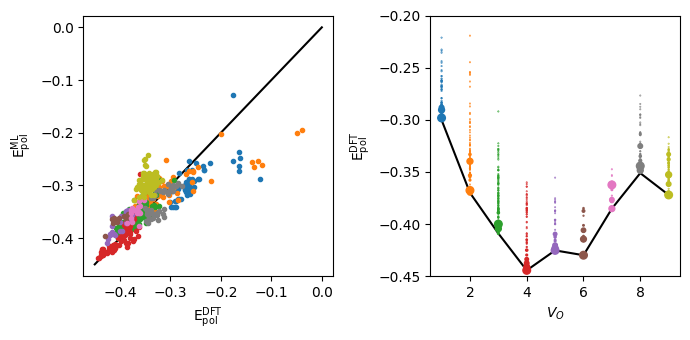

In [17]:
plt.figure(figsize=(7,3.5), dpi=100)
show = [1,2,3,4,5,6,7,8,9]

plt.subplot(1,2,1)
for i in show:
    plt.plot(res[i]['test']['true'], res[i]['test']['pred'], '.', label=str(i)+' $V_O$')
plt.plot([-0.45,-0.0],[-0.45,-0.0],'k', zorder=0)
plt.xlabel('E$_\mathrm{pol}^\mathrm{DFT}$')
plt.ylabel('E$_\mathrm{pol}^\mathrm{ML}$')


plt.subplot(1,2,2)
plt.plot([i for i in show],
         [np.min(res[i]['test']['true']) for i in show],
         'k', zorder=0)

for i in show:
    values = res[i]['test']['true'][np.argsort(res[i]['test']['pred'])]
    x = np.linspace(0,1*len(values),len(values))
    s = (np.exp(-0.5*x)+0.005)*30
    plt.scatter(res[i]['test']['nbs'], values, s=s)
plt.ylim([-0.45,-0.2])
plt.xlabel('$V_O$')
plt.ylabel('E$_\mathrm{pol}^\mathrm{DFT}$')

plt.tight_layout()